# Название проекта: "Телекоммуникации"

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. \
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.\
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).\

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Фиксируем значение random_state
RANDOM_STATE = 250923

## Загрузка данных

In [3]:
try:
    df_contract = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Выпускной проект/contract_new.csv')
    df_internet = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Выпускной проект/internet_new.csv')
    df_personal = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Выпускной проект/personal_new.csv')
    df_phone = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Выпускной проект/phone_new.csv')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')

## Исследование каждого датафрейма

### Contract

In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


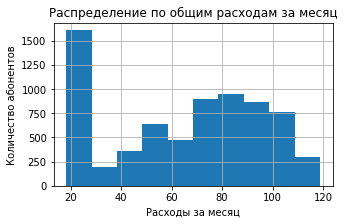

In [7]:
df_contract.hist(figsize=(5, 3))
plt.title('Распределение по общим расходам за месяц')
plt.xlabel('Расходы за месяц')
plt.ylabel('Количество абонентов')
plt.show()

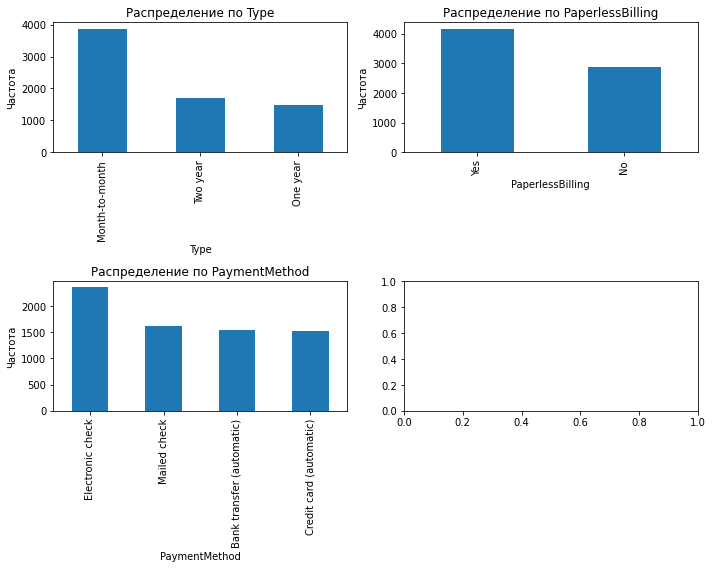

In [8]:
num_rows = 2  # Количество рядов
num_cols = 2  # Количество колонок

# Создание сетки графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Переменные для отслеживания текущего ряда и колонки
curr_row = 0
curr_col = 0

# Перебор столбцов датафрейма
for column in df_contract[['Type', 'PaperlessBilling', 'PaymentMethod']].columns:
    # Построение графика распределения данных в столбце
    df_contract[column].value_counts().plot(kind='bar', ax=axes[curr_row][curr_col])
    axes[curr_row][curr_col].set_title(f'Распределение по {column}')
    axes[curr_row][curr_col].set_xlabel(column)
    axes[curr_row][curr_col].set_ylabel('Частота')

    # Обновляем текущую позицию в сетке
    curr_col += 1
    if curr_col == num_cols:
        curr_row += 1
        curr_col = 0

# Устранение пустых ячеек в сетке
if curr_row < num_rows - 1 or curr_col < num_cols - 1:
    for row in range(curr_row, num_rows):
        for col in range(curr_col, num_cols):
            axes[row][col].axis('off')
            
# Вывод графиков
plt.tight_layout()
plt.show()

В столбце total_charges тип данных указан object, в предобработке нужно будет изменить на float.\
Также столбец с датой 'BeginDate' нужно заменить на тип данных datetime.\
Также можно отметить, что в этом датафрейме нет пропусков.\
По графику видно, что наиболее частые расходы за месяц находятся в районе 18-35.

### Internet

In [9]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5816-JMLGY,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


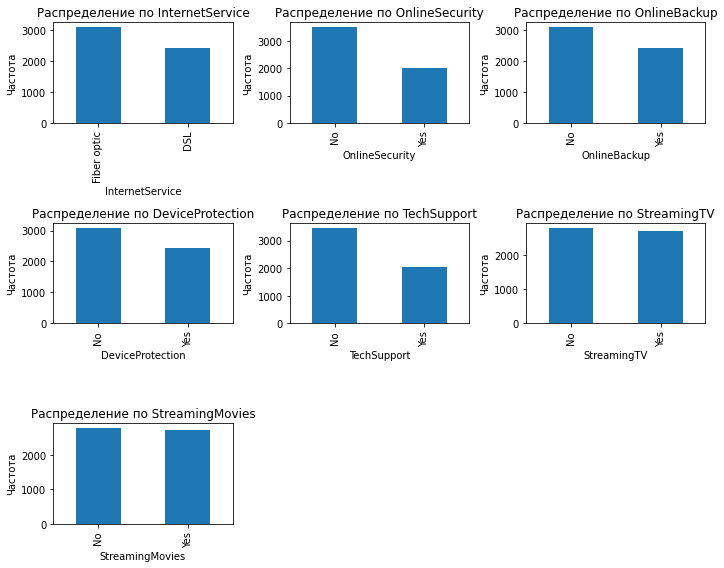

In [12]:
num_rows = 3  # Количество рядов
num_cols = 3  # Количество колонок

# Создание сетки графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Переменные для отслеживания текущего ряда и колонки
curr_row = 0
curr_col = 0

# Перебор столбцов датафрейма
for column in df_internet.drop('customerID', axis=1).columns:
    # Построение графика распределения данных в столбце
    df_internet[column].value_counts().plot(kind='bar', ax=axes[curr_row][curr_col])
    axes[curr_row][curr_col].set_title(f'Распределение по {column}')
    axes[curr_row][curr_col].set_xlabel(column)
    axes[curr_row][curr_col].set_ylabel('Частота')

    # Обновляем текущую позицию в сетке
    curr_col += 1
    if curr_col == num_cols:
        curr_row += 1
        curr_col = 0

# Устранение пустых ячеек в сетке
if curr_row < num_rows - 1 or curr_col < num_cols - 1:
    for row in range(curr_row, num_rows):
        for col in range(curr_col, num_cols):
            axes[row][col].axis('off')
            
# Вывод графиков
plt.tight_layout()
plt.show()

В датафрейме 'internet' все данные категориальные, и имеют тип object.\
Пропуски также отсутствуют.

### Personal

In [13]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


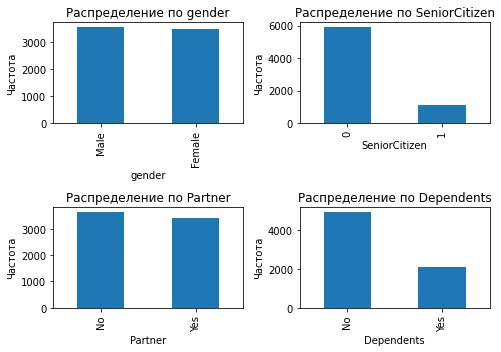

In [16]:
num_rows = 2  # Количество рядов
num_cols = 2  # Количество колонок

# Создание сетки графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 5))

# Переменные для отслеживания текущего ряда и колонки
curr_row = 0
curr_col = 0

# Перебор столбцов датафрейма
for column in df_personal.drop('customerID', axis=1).columns:
    # Построение графика распределения данных в столбце
    df_personal[column].value_counts().plot(kind='bar', ax=axes[curr_row][curr_col])
    axes[curr_row][curr_col].set_title(f'Распределение по {column}')
    axes[curr_row][curr_col].set_xlabel(column)
    axes[curr_row][curr_col].set_ylabel('Частота')

    # Обновляем текущую позицию в сетке
    curr_col += 1
    if curr_col == num_cols:
        curr_row += 1
        curr_col = 0

# Вывод графиков
plt.tight_layout()
plt.show()

В данном датафрейме также отсутствуют пропуски, все столбцы также категориальные.\
Также можно отметить, что среди абонентов 16.2% являются пенсионерами.\
Распределение по полу примерно 50 на 50.\
И также абонентов без детей гораздо больше.

### Phone

In [17]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [18]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4749-VFKVB,No
freq,1,3390


<AxesSubplot:>

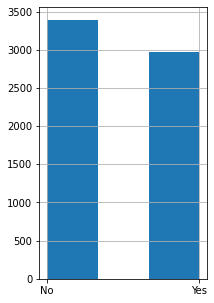

In [20]:
df_phone['MultipleLines'].hist(figsize=(3, 5), bins=3)

По данному датафрейму можно сказать, что чаще абоненты подключаются только к одной линии одновременно, чем к нескольким.

##### План работы по пунктам

- Ознакомился с данными;
- Провести предобработку данных:\
  Объединить таблицы;\
  Создать дополнительный признак длительности "жизни" клиента;\
  Обработать пропуски в данных, которые возникнут из-за разных размеров датафреймов;\
  Обработать аномалии, если будут
- Сделать анализ общего датасета;
- Сделать разделение данных на обучающую и тестовую выборки;
- Попробовать различные модели (на данном этапе пока не определился какие), используя пайплайны для подбора гиперпараметров;
- Анализ лучшей модели;
- Проверка лучшей модели на тестовой выборке
- Итоговый вывод по проекту

## Часть 2

### Предобработка данных

##### Преобразование столбцов с датами к типу datetime

In [21]:
df_contract['BeginDate']

0       2020-01-01
1       2017-04-01
2       2019-10-01
3       2016-05-01
4       2019-09-01
           ...    
7038    2018-02-01
7039    2014-02-01
7040    2019-03-01
7041    2019-07-01
7042    2014-08-01
Name: BeginDate, Length: 7043, dtype: object

In [22]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [23]:
df_contract['BeginDate']

0      2020-01-01
1      2017-04-01
2      2019-10-01
3      2016-05-01
4      2019-09-01
          ...    
7038   2018-02-01
7039   2014-02-01
7040   2019-03-01
7041   2019-07-01
7042   2014-08-01
Name: BeginDate, Length: 7043, dtype: datetime64[ns]

In [24]:
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'] = np.NaN

In [25]:
df_contract['EndDate'].unique()

array([nan, '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', '

In [26]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])

#### Выделение целевого признака

In [27]:
df_contract['target'] = (~df_contract['EndDate'].isnull())

In [28]:
df_contract['target'].unique()

array([False,  True])

In [29]:
df_contract['target'] = df_contract['target'].astype(int)

In [30]:
df_contract['target'].unique()

array([0, 1])

#### Создание доп. признака о длительности жизни клиента

In [31]:
#создание доп. признака о длительности жизни клиента в датафрейме contract
df_contract['EndDate'].value_counts()

2020-01-01    39
2019-12-01    38
2018-11-01    35
2019-09-01    32
2019-10-01    31
              ..
2014-12-01     2
2015-04-01     2
2014-06-01     1
2014-11-01     1
2014-10-01     1
Name: EndDate, Length: 66, dtype: int64

In [32]:
sorted(df_contract['EndDate'].unique())[1]

numpy.datetime64('2014-06-01T00:00:00.000000000')

In [33]:
sorted(df_contract['EndDate'].unique())[-1]

numpy.datetime64('2020-01-01T00:00:00.000000000')

Последняя дата начала контракта числится за 01.01.2020. Соответственно длительность жизни будет считаться с самой первой даты до текущей.

In [34]:
df_contract.loc[(~df_contract['EndDate'].isnull()), 'BeginDate']

9      2014-12-01
15     2014-05-01
25     2017-08-01
30     2014-03-01
35     2014-02-01
          ...    
7004   2016-12-01
7005   2018-03-01
7006   2016-09-01
7012   2014-12-01
7034   2014-03-01
Name: BeginDate, Length: 1101, dtype: datetime64[ns]

In [35]:
df_contract[df_contract['EndDate'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.5,0
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,2035.2,0
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7430.4,0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,325.6,0
7041,8361-LTMKD,2019-07-01,NaT,Month-to-month,Yes,Mailed check,74.40,520.8,0


В столбце EndDate очень много пропусков, которые необходимо заполнить. Так как даты окончания контракта еще нет, значит он еще действующий, и можно указать текущую дату для расчета длительности жизни клиента.

In [36]:
df_contract.loc[df_contract['EndDate'].isnull(), 'EndDate'] = '2020-02-01T00:00:00.000000000'

In [37]:
df_contract['EndDate'].unique()

array(['2020-02-01T00:00:00.000000000', Timestamp('2017-05-01 00:00:00'),
       Timestamp('2016-03-01 00:00:00'), Timestamp('2018-09-01 00:00:00'),
       Timestamp('2018-11-01 00:00:00'), Timestamp('2018-12-01 00:00:00'),
       Timestamp('2019-08-01 00:00:00'), Timestamp('2018-07-01 00:00:00'),
       Timestamp('2017-09-01 00:00:00'), Timestamp('2015-09-01 00:00:00'),
       Timestamp('2016-07-01 00:00:00'), Timestamp('2016-06-01 00:00:00'),
       Timestamp('2018-03-01 00:00:00'), Timestamp('2019-02-01 00:00:00'),
       Timestamp('2018-06-01 00:00:00'), Timestamp('2019-06-01 00:00:00'),
       Timestamp('2020-01-01 00:00:00'), Timestamp('2019-11-01 00:00:00'),
       Timestamp('2016-09-01 00:00:00'), Timestamp('2015-06-01 00:00:00'),
       Timestamp('2016-12-01 00:00:00'), Timestamp('2019-05-01 00:00:00'),
       Timestamp('2019-04-01 00:00:00'), Timestamp('2017-06-01 00:00:00'),
       Timestamp('2017-08-01 00:00:00'), Timestamp('2018-04-01 00:00:00'),
       Timestamp('2018-08-

In [ ]:
df_contract['duration'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract.head()

In [ ]:
df_contract['duration'] = df_contract['duration'].dt.days
df_contract.head()

Далее столбцы с датами больше не понадобятся, их можно удалить

In [40]:
df_contract = df_contract.drop(['BeginDate', 'EndDate'], axis=1)
df_contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,0


#### Объединение таблиц

In [41]:
df_1 = pd.merge(df_contract, df_internet, on='customerID', how='outer')
df_2 = pd.merge(df_1, df_personal, on='customerID', how='outer')
df = pd.merge(df_2, df_phone, on='customerID', how='outer')
df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,0,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   target            7043 non-null   int64  
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null   object 


In [43]:
#Также можно удалить столбец total charges так как ежемесячный траты гораздо важнее общих
df = df.drop('TotalCharges', axis=1)
df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


#### Обработка пропусков и аномалий

После объединения образовалось большое количество пропусков в некоторых признаках.\
Т.к. данных и так не очень много, просто избавиться от этих строк нельзя.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   target            7043 non-null   int64  
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  gender            7043 non-null   object 
 14  SeniorCitizen     7043 non-null   int64  
 15  Partner           7043 non-null   object 
 16  Dependents        7043 non-null   object 


Пропуски означают, что этими услугами клиенты не пользовались, соответственно можно проставить значение, которое будет обозначать неиспользованную услугу.

In [45]:
df = df.fillna('not_used')
df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,not_used
1,5575-GNVDE,One year,No,Mailed check,56.95,0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,not_used
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   target            7043 non-null   int64  
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  gender            7043 non-null   object 
 14  SeniorCitizen     7043 non-null   int64  
 15  Partner           7043 non-null   object 
 16  Dependents        7043 non-null   object 


#### Разбивка данных на выборки

In [47]:
train, test = train_test_split(df, random_state=RANDOM_STATE, test_size=0.25)

features_train = train.drop('target', axis=1)
target_train = train['target']

features_test = test.drop('target', axis=1)
target_test = test['target']

In [48]:
features_train

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
1634,9995-HOTOH,Two year,No,Electronic check,59.00,DSL,Yes,Yes,Yes,No,Yes,Yes,Male,0,Yes,Yes,not_used
6889,7952-OBOYL,Month-to-month,Yes,Mailed check,89.85,Fiber optic,No,No,Yes,Yes,Yes,No,Male,0,No,No,No
6630,1226-IENZN,Month-to-month,Yes,Electronic check,78.75,Fiber optic,No,No,No,No,No,Yes,Male,1,No,No,No
4261,6195-MELTI,One year,Yes,Mailed check,54.65,DSL,No,Yes,No,Yes,No,No,Male,0,No,No,No
6785,3090-HAWSU,Two year,Yes,Credit card (automatic),111.60,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,0,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,1450-GALXR,Month-to-month,Yes,Electronic check,98.50,Fiber optic,No,No,No,Yes,Yes,Yes,Female,0,No,No,Yes
3840,1080-BWSYE,Two year,No,Credit card (automatic),25.65,not_used,not_used,not_used,not_used,not_used,not_used,not_used,Male,1,Yes,No,Yes
935,6630-UJZMY,Month-to-month,Yes,Electronic check,83.25,Fiber optic,No,No,No,No,Yes,No,Female,1,Yes,No,Yes
4395,5502-RLUYV,Month-to-month,Yes,Electronic check,103.95,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes


In [49]:
target_train

1634    0
6889    0
6630    0
4261    0
6785    1
       ..
801     0
3840    0
935     0
4395    1
4264    0
Name: target, Length: 5282, dtype: int64

In [50]:
features_train['SeniorCitizen'] = features_train['SeniorCitizen'].replace({0:'No', 1:'Yes'})
features_train['SeniorCitizen']

1634     No
6889     No
6630    Yes
4261     No
6785     No
       ... 
801      No
3840    Yes
935     Yes
4395     No
4264    Yes
Name: SeniorCitizen, Length: 5282, dtype: object

In [51]:
features_train.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
1634,9995-HOTOH,Two year,No,Electronic check,59.00,DSL,Yes,Yes,Yes,No,Yes,Yes,Male,No,Yes,Yes,not_used
6889,7952-OBOYL,Month-to-month,Yes,Mailed check,89.85,Fiber optic,No,No,Yes,Yes,Yes,No,Male,No,No,No,No
6630,1226-IENZN,Month-to-month,Yes,Electronic check,78.75,Fiber optic,No,No,No,No,No,Yes,Male,Yes,No,No,No
4261,6195-MELTI,One year,Yes,Mailed check,54.65,DSL,No,Yes,No,Yes,No,No,Male,No,No,No,No
6785,3090-HAWSU,Two year,Yes,Credit card (automatic),111.60,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,No,No,No,Yes


In [53]:
categorical_columns = features_train.drop(['customerID', 'duration', 'MonthlyCharges'], axis=1).columns
categorical_columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines'],
      dtype='object')

In [54]:
features_train[categorical_columns] = features_train[categorical_columns].astype('category')
features_test[categorical_columns] = features_test[categorical_columns].astype('category')

In [55]:
features_train.set_index('customerID', inplace=True)
features_test.set_index('customerID', inplace=True)

## Обучение моделей

In [56]:
transformer = ColumnTransformer([
    ('numbers', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('category', OneHotEncoder(drop='first'), make_column_selector(dtype_include='category'))
])

##### RandomForestClassifier

In [118]:
pipeline_rf = Pipeline([
    ('transformer', transformer),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [119]:
param_grid = {
    'classifier__n_estimators': [20, 30, 50, 100],
    'classifier__max_depth': [2, 4, 8, 12],
    'classifier__min_samples_leaf': [2, 4, 8, 12]
}

In [120]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=3)

In [121]:
grid_search_rf.fit(features_train, target_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=20;, score=0.805 total time=   0.1s
[CV 2/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=20;, score=0.779 total time=   0.1s
[CV 3/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=20;, score=0.780 total time=   0.1s
[CV 4/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=20;, score=0.776 total time=   0.1s
[CV 5/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=20;, score=0.788 total time=   0.1s
[CV 1/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=30;, score=0.792 total time=   0.2s
[CV 2/5] END classifier__max_depth=2, classifier__min_samples_leaf=2, classifier__n_estimators=30;, score=0.766 total time=   0.1s
[CV 3/5] END classifi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numbers',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000181C8505A60>),
                                                                        ('category',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000181C8519670>)])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=250923))]),
     

In [122]:
grid_search_rf.best_params_

{'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 100}

In [124]:
best_model_rf = grid_search_rf.best_estimator_

In [125]:
grid_search_rf.best_score_

0.8184368975206556

##### LogisticRegression

In [126]:
pipeline_lr = Pipeline([
    ('transformer', transformer),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', verbose=3))
])

In [127]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 10.0]
}

In [128]:
grid_search_lr = GridSearchCV(pipeline_lr, param_grid, cv=5, scoring='roc_auc')

In [129]:
grid_search_lr.fit(features_train, target_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numbers',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000181C8505A60>),
                                                                        ('category',
                                                                         OneHotEncoder(drop='first'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000181C8519670>)])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=250923,
                 

In [130]:
grid_search_lr.best_params_

{'classifier__C': 1.0, 'classifier__penalty': 'l2'}

In [131]:
best_model_lr = grid_search_lr.best_estimator_

In [132]:
grid_search_lr.best_score_

0.7497304524024706

##### CatBoost

In [133]:
#индексы категориальных признаков для catboost
cat_feature_indices = [features_train.columns.get_loc(feature_name) for feature_name in categorical_columns]

In [134]:
cat_feature_indices

[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [135]:
pipeline_cat = Pipeline([
    ('classifier', CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_feature_indices))
])

In [136]:
param_grid = {
    'classifier__iterations': [100, 200, 300],  # количество итераций
    'classifier__learning_rate': [0.01, 0.1, 1.0],  # скорость обучения
    'classifier__depth': [3, 5, 7],  # глубина деревьев
}

In [137]:
grid_search_cat = GridSearchCV(pipeline_cat, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=5)

In [138]:
grid_search_cat.fit(features_train, target_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.3959095	total: 158ms	remaining: 31.4s
1:	learn: 0.3605305	total: 176ms	remaining: 17.4s
2:	learn: 0.3446405	total: 196ms	remaining: 12.9s
3:	learn: 0.3390168	total: 217ms	remaining: 10.6s
4:	learn: 0.3336396	total: 235ms	remaining: 9.18s
5:	learn: 0.3305197	total: 247ms	remaining: 8s
6:	learn: 0.3296800	total: 265ms	remaining: 7.31s
7:	learn: 0.3268052	total: 285ms	remaining: 6.83s
8:	learn: 0.3245887	total: 303ms	remaining: 6.43s
9:	learn: 0.3227838	total: 323ms	remaining: 6.14s
10:	learn: 0.3184956	total: 342ms	remaining: 5.88s
11:	learn: 0.3144856	total: 363ms	remaining: 5.68s
12:	learn: 0.3098449	total: 387ms	remaining: 5.57s
13:	learn: 0.3064254	total: 414ms	remaining: 5.5s
14:	learn: 0.3009089	total: 433ms	remaining: 5.34s
15:	learn: 0.2994823	total: 451ms	remaining: 5.19s
16:	learn: 0.2994319	total: 472ms	remaining: 5.08s
17:	learn: 0.2991824	total: 490ms	remaining: 4.95s
18:	learn: 0.2970601	total: 511ms	

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x00000181C8A50DC0>)]),
             n_jobs=-1,
             param_grid={'classifier__depth': [3, 5, 7],
                         'classifier__iterations': [100, 200, 300],
                         'classifier__learning_rate': [0.01, 0.1, 1.0]},
             scoring='roc_auc', verbose=5)

In [139]:
grid_search_cat.best_params_

{'classifier__depth': 3,
 'classifier__iterations': 200,
 'classifier__learning_rate': 1.0}

In [140]:
best_model_cat = grid_search_cat.best_estimator_

In [143]:
grid_search_cat.best_score_

0.9064682183935991

## Проверка лучшей модели на тестовой выборке

In [148]:
score = roc_auc_score(target_test, best_model_cat.predict_proba(features_test)[:, 1])
score

0.8957439646051746

## Проверка значимости признаков модели

In [157]:
best_model = grid_search_cat.best_estimator_.named_steps['classifier']

# Получение важности признаков
importances = best_model.feature_importances_

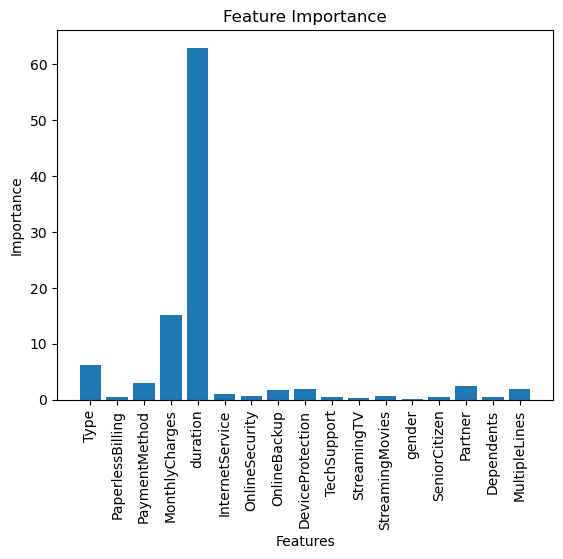

In [161]:
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), features_train.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

В итоге, наилучшая модель показала результат roc_auc равный 0.896.\
Наиболее важными признаками являются: 'duration', 'MonthlyCharges' и 'Type'.\
А наименее важными получились 'gender', 'StreamingTV', 'PaperlessBilling' и 'SeniorCitizen'.

<div style="border:solid orange 2px; padding: 20px"> 

## Вывод

Для работы над проектом были предоставлены данные в 4 датафреймах, эти данные предстояло подгрузить и ознакомиться с ними.\
Далее был проведен исследовательский анализ предоставленных данных, построены графики распределений каждых признаков в датафреймах.\
Датафреймы были разными по количеству данных, так как были услуги, которыми клиенты не пользовались, соответственно данных в определенных столбцах было меньше.

Далее предстояло провести предобработку данных:
- Изначально были обработаны столбцы, у которых был некорректный тип данных;
- Затем был выделен целевой признак в отдельную колонку, где было отмечено, является ли человек клиентом или уже нет;
- Был создан дополнительный признак "длительность жизни клиента";
- Были удалены признаки со временем;
- Были объединены таблицы по столбцу 'customerID';
- Далее необходимо было обработать пропуски, возникшие после объединения таблиц, были объединены они с помощью заполнения всех пропусков значением 'not_used';

После предобработки данные были разбиты на обучающую и тестовую выборки.

Далее уже был выбор и обучение моделей:
- Были выбраны LogisticRegression, RandomForestClassifier и CatBoostClassifier;
- При помощи пайплайна были масштабированы и кодированы признаки перед обучением;
- Далее при помощи GridSearchCV были обработаны различные гиперпараметры, для выявления лучших;
- Далее модели были обучены и получены результаты метрики 'roc_auc' на обучающих выборках.

Результат на обучающей выборке был лучшим у CatBoostClassifier, который был равен 0.906, поэтому эта модель была выбрана для тестирования.

Результат лучшей модели на тестовой выборке получился равен 0.896, что удовлетворяет условию поставленной задачи.

Итоговая модель выглядит следующим образом.\
CatBoostClassifier()\
Подобранные гиперпараметры:
- depth = 3;
- iterations = 200;
- learning_rate = 1.0

ROC_AUC равен 0.896

Список признаков, используемых для обучения лучшей модели:\
['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'duration', 'MonthlyCharges'].
       
Описание предобработки было выше.